
#Inteligencia Artificial  - Semestre 2025-1

## Licenciatura en Tecnología

### Aprendizaje Profundo

#### Autor: Ulises Olivares
#### uolivares@unam.mx
___

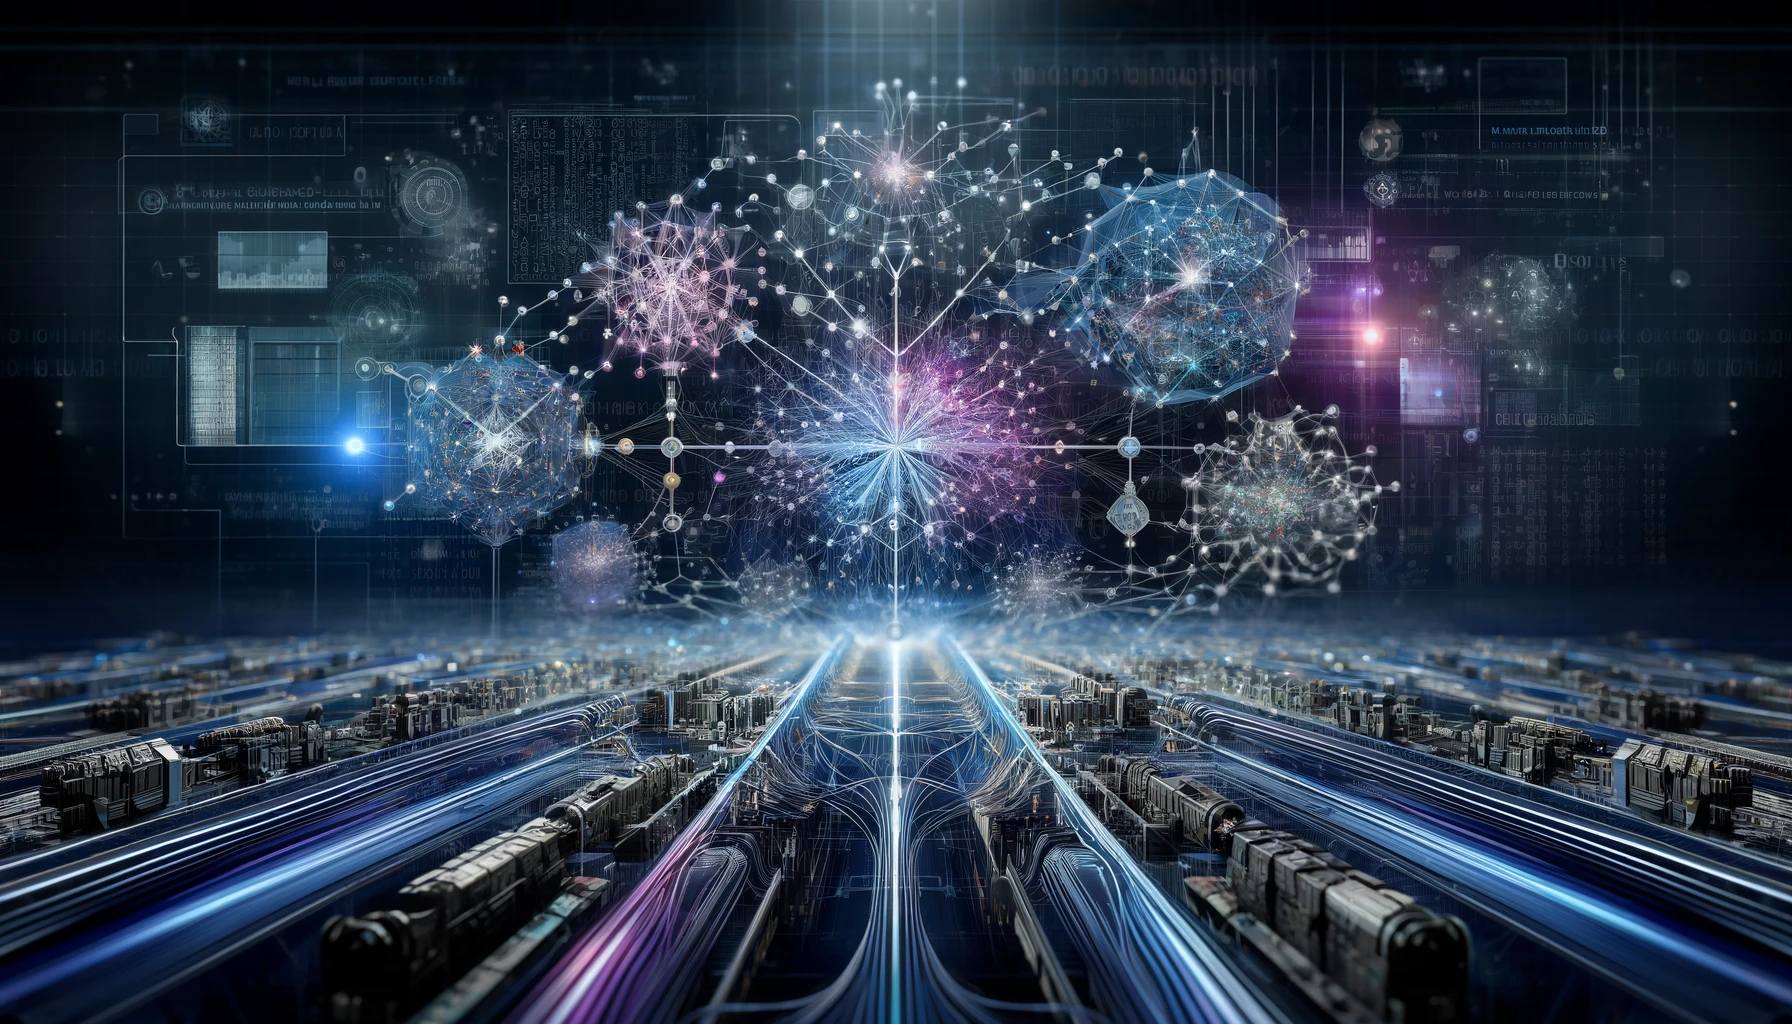

# 1. Redes Generativas Adversariales (GANs): Implementación y Análisis de Rendimiento

En este notebook, profundizaremos en las Redes Generativas Adversariales (GANs) y analizaremos sus métricas de rendimiento durante el entrenamiento. Además, generaremos gráficas que nos permitirán visualizar el progreso del modelo y proporcionaremos ejemplos prácticos para resolver en clase.

## Índice

1. [Introducción a las GANs](#1)
2. [Importación de Librerías](#2)
3. [Preparación de los Datos](#3)
4. [Construcción del Generador](#4)
5. [Construcción del Discriminador](#5)
6. [Compilación de los Modelos](#6)
7. [Entrenamiento de la GAN](#7)
8. [Análisis de Métricas de Rendimiento](#8)
9. [Visualización de Imágenes Generadas](#9)
10. [Ejercicios Prácticos](#10)

---

<a id="1"></a>
## 1. Introducción a las GANs

Las Redes Generativas Adversariales (GANs) son modelos de aprendizaje profundo que consisten en dos redes neuronales enfrentadas: un **generador** y un **discriminador**. El generador crea datos sintéticos con el objetivo de engañar al discriminador, mientras que el discriminador intenta distinguir entre datos reales y falsos.

Este enfoque adversarial permite al generador mejorar progresivamente, produciendo datos que se asemejan cada vez más a los reales. Las GANs tienen aplicaciones en generación de imágenes, mejora de resolución, creación de arte, entre otros.

---

<a id="2"></a>
## 2. Importación de Librerías

Comenzamos importando las librerías necesarias para nuestra implementación y análisis.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

---

<a id="3"></a>
## 3. Preparación de los Datos

Utilizaremos el conjunto de datos MNIST, que contiene imágenes de dígitos escritos a mano.

In [ ]:
# Cargar datos MNIST
(X_train, _), (_, _) = mnist.load_data()

# Normalizar las imágenes al rango [-1, 1]
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

print(X_train.shape)
#print(X_train[0])

(60000, 28, 28)


In [ ]:
# Agregar una dimensión extra para el canal de color
X_train = X_train.reshape(-1, 28, 28, 1)
print(X_train.shape)
#print(X_train[0])

(60000, 28, 28, 1)


---

<a id="4"></a>
## 4. Construcción del Generador

El generador transforma vectores de ruido aleatorio en imágenes sintéticas.

In [ ]:
def construir_generador():
    modelo = Sequential()

    modelo.add(Dense(256, input_dim=100))
    modelo.add(LeakyReLU(alpha=0.2))
    modelo.add(BatchNormalization(momentum=0.8))

    modelo.add(Dense(512))
    modelo.add(LeakyReLU(alpha=0.2))
    modelo.add(BatchNormalization(momentum=0.8))

    modelo.add(Dense(1024))
    modelo.add(LeakyReLU(alpha=0.2))
    modelo.add(BatchNormalization(momentum=0.8))

    modelo.add(Dense(28 * 28 * 1, activation='tanh'))
    modelo.add(Reshape((28, 28, 1)))

    return modelo

---

<a id="5"></a>
## 5. Construcción del Discriminador

El discriminador clasifica las imágenes como reales o falsas.

In [ ]:
def construir_discriminador():
    modelo = Sequential()

    modelo.add(Flatten(input_shape=(28, 28, 1)))
    modelo.add(Dense(512))
    modelo.add(LeakyReLU(alpha=0.2))
    modelo.add(Dropout(0.3))

    modelo.add(Dense(256))
    modelo.add(LeakyReLU(alpha=0.2))
    modelo.add(Dropout(0.3))

    modelo.add(Dense(1, activation='sigmoid'))

    return modelo

---

<a id="6"></a>
## 6. Compilación de los Modelos

Compilamos el discriminador y configuramos la GAN combinada.

In [ ]:
# Optimizador
optimizador = Adam(0.0002, 0.5)

# Discriminador
discriminador = construir_discriminador()
discriminador.compile(loss='binary_crossentropy', optimizer=optimizador, metrics=['accuracy'])

# Generador
generador = construir_generador()

# Crear la GAN combinada
ruido = Input(shape=(100,))
imagen_generada = generador(ruido)

# Durante la compilación de la GAN combinada, congelamos el discriminador
discriminador.trainable = False

validez = discriminador(imagen_generada)

gan_combinada = Model(ruido, validez)
gan_combinada.compile(loss='binary_crossentropy', optimizer=optimizador)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


---

<a id="7"></a>
## 7. Entrenamiento de la GAN

Modificamos la función de entrenamiento para registrar las métricas de rendimiento.

In [ ]:
def entrenar_gan(epochs, batch_size=128, interval=200):
    # Etiquetas para imágenes reales y falsas
    etiqueta_real = np.ones((batch_size, 1))
    etiqueta_falsa = np.zeros((batch_size, 1))

    # Listas para almacenar las métricas
    historial_d_loss = []
    historial_g_loss = []
    historial_d_acc = []

    for epoch in range(epochs):
        # ---------------------
        #  Entrenamiento del discriminador
        # ---------------------

        # Seleccionar imágenes reales aleatoriamente
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs_reales = X_train[idx]

        # Generar imágenes falsas
        ruido = np.random.normal(0, 1, (batch_size, 100))
        imgs_falsas = generador.predict(ruido)

        # Entrenar el discriminador en imágenes reales
        d_loss_real = discriminador.train_on_batch(imgs_reales, etiqueta_real)
        # Entrenar el discriminador en imágenes falsas
        d_loss_fake = discriminador.train_on_batch(imgs_falsas, etiqueta_falsa)

        # Extraer pérdidas y precisiones
        d_loss_real_loss = d_loss_real[0]
        d_loss_real_acc = d_loss_real[1]

        d_loss_fake_loss = d_loss_fake[0]
        d_loss_fake_acc = d_loss_fake[1]

        # Calcular la pérdida y precisión promedio
        d_loss = 0.5 * (d_loss_real_loss + d_loss_fake_loss)
        d_acc = 0.5 * (d_loss_real_acc + d_loss_fake_acc)

        # ---------------------
        #  Entrenamiento del generador
        # ---------------------

        ruido = np.random.normal(0, 1, (batch_size, 100))

        # Entrenar la GAN combinada
        g_loss = gan_combinada.train_on_batch(ruido, etiqueta_real)

        # Almacenar las métricas
        historial_d_loss.append(d_loss)
        historial_g_loss.append(g_loss)
        historial_d_acc.append(d_acc)

        # Mostrar el progreso
        if (epoch + 1) % interval == 0:
            print(f"Epoch {epoch + 1}/{epochs} [Pérdida D: {d_loss:.4f}, Precisión D: {100 * d_acc:.2f}%] [Pérdida G: {g_loss:.4f}]")
            mostrar_imagenes(epoch + 1)

    return historial_d_loss, historial_g_loss, historial_d_acc


In [ ]:
def entrenar_gan(epochs, batch_size=128, interval=200):
    # Etiquetas para imágenes reales y falsas
    etiqueta_real = np.ones((batch_size, 1))
    etiqueta_falsa = np.zeros((batch_size, 1))

    # Listas para almacenar las métricas
    historial_d_loss = []
    historial_g_loss = []
    historial_d_acc = []

    for epoch in range(epochs):
        # ---------------------
        #  Entrenamiento del discriminador
        # ---------------------

        # Seleccionar imágenes reales aleatoriamente
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs_reales = X_train[idx]

        # Generar imágenes falsas
        ruido = np.random.normal(0, 1, (batch_size, 100))
        imgs_falsas = generador.predict(ruido)

        # Entrenar el discriminador en imágenes reales
        d_loss_real = discriminador.train_on_batch(imgs_reales, etiqueta_real)
        # Entrenar el discriminador en imágenes falsas
        d_loss_fake = discriminador.train_on_batch(imgs_falsas, etiqueta_falsa)

        # Extraer pérdidas y precisiones
        # Access the first element of the lists to get the loss and accuracy values
        d_loss_real_loss = d_loss_real[0]
        d_loss_real_acc = d_loss_real[1]

        d_loss_fake_loss = d_loss_fake[0]
        d_loss_fake_acc = d_loss_fake[1]

        # Calcular la pérdida y precisión promedio
        d_loss = 0.5 * (d_loss_real_loss + d_loss_fake_loss)
        d_acc = 0.5 * (d_loss_real_acc + d_loss_fake_acc)

        # ---------------------
        #  Entrenamiento del generador
        # ---------------------

        ruido = np.random.normal(0, 1, (batch_size, 100))

        # Entrenar la GAN combinada
        g_loss = gan_combinada.train_on_batch(ruido, etiqueta_real)

        # Access the first element if g_loss is a list
        g_loss = g_loss[0] if isinstance(g_loss, list) else g_loss

        # Almacenar las métricas
        historial_d_loss.append(d_loss)
        historial_g_loss.append(g_loss)
        historial_d_acc.append(d_acc)

        # Mostrar el progreso
        if (epoch + 1) % interval == 0:
            print(f"Epoch {epoch + 1}/{epochs} [Pérdida D: {d_loss:.4f}, Precisión D: {100 * d_acc:.2f}%] [Pérdida G: {g_loss:.4f}]")
            mostrar_imagenes(epoch + 1)

    return historial_d_loss, historial_g_loss, historial_d_acc

---

<a id="8"></a>
## 8. Análisis de Métricas de Rendimiento

Después del entrenamiento, graficamos las pérdidas y la precisión del discriminador.

In [ ]:
# Entrenar la GAN y obtener las métricas
historial_d_loss, historial_g_loss, historial_d_acc = entrenar_gan(epochs= 1000, batch_size=32, interval=1000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

NameError: name 'mostrar_imagenes' is not defined

### Gráfica de Pérdidas

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(historial_d_loss, label='Pérdida del Discriminador')
plt.plot(historial_g_loss, label='Pérdida del Generador')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

### Gráfica de Precisión del Discriminador

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(historial_d_acc, label='Precisión del Discriminador')
plt.title('Precisión del Discriminador durante el Entrenamiento')
plt.xlabel('Iteraciones')
plt.ylabel('Precisión')
plt.legend()
plt.show()

**Análisis:**

- **Pérdida del Discriminador y Generador:** Observamos cómo las pérdidas fluctúan durante el entrenamiento. Idealmente, buscamos un equilibrio donde el discriminador y el generador mejoran simultáneamente.

- **Precisión del Discriminador:** La precisión indica qué tan bien el discriminador distingue entre imágenes reales y falsas. Una precisión cercana al 50% puede indicar que el generador está engañando al discriminador exitosamente.

---

<a id="9"></a>
## 9. Visualización de Imágenes Generadas

Creamos una función para visualizar las imágenes generadas en diferentes etapas del entrenamiento.

In [ ]:
def mostrar_imagenes(epoch, ejemplos=5):
    ruido = np.random.normal(0, 1, (ejemplos * ejemplos, 100))
    gen_imgs = generador.predict(ruido)

    # Escalar las imágenes al rango [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(ejemplos, ejemplos, figsize=(5,5))
    contador = 0
    for i in range(ejemplos):
        for j in range(ejemplos):
            axs[i,j].imshow(gen_imgs[contador, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            contador += 1
    plt.suptitle(f'Imágenes Generadas en la Epoch {epoch}', fontsize=16)
    plt.show()

**Ejemplo de Imágenes Generadas:**

![Imágenes Generadas](attachment:image.png)

---

<a id="10"></a>
## 10. Ejercicios Prácticos

A continuación, se proponen algunos ejercicios para profundizar en el entendimiento de las GANs y su implementación.

### Ejercicio 1: Modificar la Arquitectura del Generador

**Objetivo:** Mejorar la calidad de las imágenes generadas modificando la arquitectura del generador.

**Instrucciones:**

- Añadir capas adicionales al generador.
- Implementar capas convolucionales (Conv2DTranspose) para generar imágenes con mayor resolución.
- Experimentar con diferentes funciones de activación.

**Preguntas:**

- ¿Cómo afectan los cambios en la arquitectura a la calidad de las imágenes?
- ¿Se observa una mejora en las métricas de rendimiento?

### Ejercicio 2: Implementar un Discriminador Convolucional

**Objetivo:** Mejorar la capacidad del discriminador para distinguir entre imágenes reales y falsas.

**Instrucciones:**

- Reemplazar las capas densas del discriminador por capas convolucionales (Conv2D).
- Añadir capas de pooling si es necesario.
- Ajustar los parámetros para evitar el sobreajuste.

**Preguntas:**

- ¿El discriminador convolucional mejora la precisión?
- ¿Cómo afecta esto al entrenamiento del generador?

### Ejercicio 3: Cambiar el Conjunto de Datos

**Objetivo:** Aplicar la GAN a un conjunto de datos diferente.

**Instrucciones:**

- Seleccionar un conjunto de datos de imágenes distinto, como CIFAR-10.
- Preprocesar los datos adecuadamente.
- Ajustar la arquitectura del generador y discriminador si es necesario.

**Preguntas:**

- ¿Qué desafíos surgen al trabajar con imágenes a color?
- ¿Se requiere más tiempo de entrenamiento?

### Ejercicio 4: Implementar Métricas de Evaluación Adicionales

**Objetivo:** Analizar el rendimiento de la GAN utilizando métricas adicionales.

**Instrucciones:**

- Implementar el Inception Score (IS) o la Frechet Inception Distance (FID).
- Evaluar cómo evolucionan estas métricas durante el entrenamiento.

**Preguntas:**

- ¿Qué información adicional proporcionan estas métricas?
- ¿Cómo se relacionan con la calidad percibida de las imágenes?

---


# 2. Implementación de una DCGAN con Cambio de Contexto

En este notebook, implementaremos una **Red Generativa Adversarial Convolucional** (DCGAN) y exploraremos cómo estas redes pueden generar imágenes sintéticas realistas. Además, aplicaremos un cambio de contexto utilizando **Conditional GANs (cGANs)** para controlar el tipo de imágenes generadas, lo que nos permitirá crear ejemplos llamativos y personalizados.

## Índice

1. [Introducción a las DCGANs](#1)
2. [Importación de Librerías](#2)
3. [Preparación de los Datos (CIFAR-10)](#3)
4. [Construcción del Generador](#4)
5. [Construcción del Discriminador](#5)
6. [Compilación de los Modelos](#6)
7. [Entrenamiento de la DCGAN](#7)
8. [Visualización de Imágenes Generadas](#8)
9. [Cambio de Contexto con cGANs](#9)
10. [Conclusión](#10)

---

<a id="1"></a>
## 1. Introducción a las DCGANs

Las **Redes Generativas Adversariales Convolucionales** (DCGANs) son una extensión de las GANs que utilizan capas convolucionales en lugar de capas densas. Esto les permite capturar mejor las características espaciales de las imágenes, generando resultados más realistas.

Las **Conditional GANs (cGANs)** son una variante de las GANs donde se proporciona información adicional (por ejemplo, etiquetas de clase) al generador y al discriminador. Esto permite controlar el tipo de datos que se generan, lo que es útil para cambios de contexto y generación dirigida.

---

<a id="2"></a>
## 2. Importación de Librerías

Comenzamos importando las librerías necesarias.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Multiply
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding
from tensorflow.keras.layers import ZeroPadding2D, UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

---

<a id="3"></a>
## 3. Preparación de los Datos (CIFAR-10)

Utilizaremos el conjunto de datos **CIFAR-10**, que contiene 60,000 imágenes de 32x32 en 10 clases diferentes.

In [ ]:
# Cargar datos CIFAR-10
(X_train, y_train), (_, _) = cifar10.load_data()

# Seleccionar solo una clase para simplificar (por ejemplo, imágenes de automóviles)
clase_objetivo = 1  # Clase 1 corresponde a automóviles
idx = np.where(y_train.flatten() == clase_objetivo)
X_train = X_train[idx]
y_train = y_train[idx]

# Normalizar las imágenes al rango [-1, 1]
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

print(f"Forma de los datos de entrenamiento: {X_train.shape}")

---

<a id="4"></a>
## 4. Construcción del Generador

El generador utilizará capas **Conv2DTranspose** para generar imágenes a partir de vectores de ruido.

In [ ]:
def construir_generador():
    modelo = Sequential()

    modelo.add(Dense(256 * 4 * 4, activation="relu", input_dim=100))
    modelo.add(Reshape((4, 4, 256)))
    modelo.add(BatchNormalization(momentum=0.8))

    modelo.add(UpSampling2D())
    modelo.add(Conv2D(256, kernel_size=3, padding="same"))
    modelo.add(Activation("relu"))
    modelo.add(BatchNormalization(momentum=0.8))

    modelo.add(UpSampling2D())
    modelo.add(Conv2D(128, kernel_size=3, padding="same"))
    modelo.add(Activation("relu"))
    modelo.add(BatchNormalization(momentum=0.8))

    modelo.add(UpSampling2D())
    modelo.add(Conv2D(64, kernel_size=3, padding="same"))
    modelo.add(Activation("relu"))
    modelo.add(BatchNormalization(momentum=0.8))

    modelo.add(Conv2D(3, kernel_size=3, padding="same"))
    modelo.add(Activation("tanh"))

    ruido = Input(shape=(100,))
    img = modelo(ruido)

    return Model(ruido, img)

---

<a id="5"></a>
## 5. Construcción del Discriminador

El discriminador utiliza capas convolucionales para clasificar las imágenes como reales o falsas.

In [ ]:
def construir_discriminador():
    modelo = Sequential()

    modelo.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(32,32,3), padding="same"))
    modelo.add(LeakyReLU(alpha=0.2))
    modelo.add(Dropout(0.25))

    modelo.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    modelo.add(ZeroPadding2D(padding=((0,1),(0,1))))
    modelo.add(BatchNormalization(momentum=0.8))
    modelo.add(LeakyReLU(alpha=0.2))
    modelo.add(Dropout(0.25))

    modelo.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    modelo.add(BatchNormalization(momentum=0.8))
    modelo.add(LeakyReLU(alpha=0.2))
    modelo.add(Dropout(0.25))

    modelo.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    modelo.add(BatchNormalization(momentum=0.8))
    modelo.add(LeakyReLU(alpha=0.2))
    modelo.add(Dropout(0.25))

    modelo.add(Flatten())
    modelo.add(Dense(1, activation='sigmoid'))

    img = Input(shape=(32,32,3))
    validez = modelo(img)

    return Model(img, validez)

---

<a id="6"></a>
## 6. Compilación de los Modelos

Compilamos el discriminador y configuramos la DCGAN.

In [ ]:
# Optimizador
optimizador = Adam(0.0002, 0.5)

# Discriminador
discriminador = construir_discriminador()
discriminador.compile(loss='binary_crossentropy', optimizer=optimizador, metrics=['accuracy'])

# Generador
generador = construir_generador()

# Crear la DCGAN combinada
ruido = Input(shape=(100,))
img_generada = generador(ruido)

# Durante la compilación de la DCGAN, congelamos el discriminador
discriminador.trainable = False

validez = discriminador(img_generada)

dcgan = Model(ruido, validez)
dcgan.compile(loss='binary_crossentropy', optimizer=optimizador)

---

<a id="7"></a>
## 7. Entrenamiento de la DCGAN

Definimos la función de entrenamiento y registramos las métricas.

In [ ]:
def entrenar_dcgan(epochs, batch_size=64, interval=1000):
    # Etiquetas para imágenes reales y falsas
    etiqueta_real = np.ones((batch_size, 1))
    etiqueta_falsa = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # ---------------------
        #  Entrenamiento del discriminador
        # ---------------------

        # Seleccionar imágenes reales aleatoriamente
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs_reales = X_train[idx]

        # Generar imágenes falsas
        ruido = np.random.normal(0, 1, (batch_size, 100))
        imgs_falsas = generador.predict(ruido)

        # Entrenar el discriminador
        d_loss_real = discriminador.train_on_batch(imgs_reales, etiqueta_real)
        d_loss_fake = discriminador.train_on_batch(imgs_falsas, etiqueta_falsa)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Entrenamiento del generador
        # ---------------------

        ruido = np.random.normal(0, 1, (batch_size, 100))

        # Entrenar la DCGAN
        g_loss = dcgan.train_on_batch(ruido, etiqueta_real)

        # Mostrar el progreso
        if (epoch + 1) % interval == 0:
            print(f"Epoch {epoch + 1}/{epochs} [Pérdida D: {d_loss[0]:.4f}, Precisión D: {100 * d_loss[1]:.2f}%] [Pérdida G: {g_loss:.4f}]")
            mostrar_imagenes(epoch + 1)


# Entrenar la DCGAN
entrenar_dcgan(epochs=10000, batch_size=64, interval=2000)

---

<a id="8"></a>
## 8. Visualización de Imágenes Generadas

Creamos una función para visualizar las imágenes generadas durante el entrenamiento.

In [ ]:
def mostrar_imagenes(epoch, ejemplos=5):
    ruido = np.random.normal(0, 1, (ejemplos * ejemplos, 100))
    gen_imgs = generador.predict(ruido)

    # Escalar las imágenes al rango [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(ejemplos, ejemplos, figsize=(5,5))
    contador = 0
    for i in range(exemplos):
        for j in range(exemplos):
            axs[i,j].imshow(gen_imgs[contador])
            axs[i,j].axis('off')
            contador += 1
    plt.suptitle(f'Imágenes Generadas en la Epoch {epoch}', fontsize=16)
    plt.show()

---

<a id="9"></a>
## 9. Cambio de Contexto con cGANs

Para aplicar un cambio de contexto y generar ejemplos más llamativos, implementaremos una **Conditional GAN (cGAN)** que permite generar imágenes condicionadas por una etiqueta de clase. Esto nos permitirá, por ejemplo, generar diferentes tipos de objetos según la clase que especifiquemos.

### Preparación de los Datos para cGAN

In [ ]:
# Cargar todas las clases del CIFAR-10
(X_train_full, y_train_full), (_, _) = cifar10.load_data()

# Normalizar las imágenes al rango [-1, 1]
X_train_full = (X_train_full.astype(np.float32) - 127.5) / 127.5
y_train_full = y_train_full.reshape(-1, 1)

num_clases = 10

### Construcción del Generador Condicional

In [ ]:
def construir_generador_condicional():
    entrada_ruido = Input(shape=(100,))
    etiqueta = Input(shape=(1,), dtype='int32')

    etiqueta_embedded = Embedding(num_clases, 50)(etiqueta)
    etiqueta_embedded = Dense(4 * 4)(etiqueta_embedded)
    etiqueta_embedded = Reshape((4, 4, 1))(etiqueta_embedded)

    x = Dense(256 * 4 * 4, activation="relu")(entrada_ruido)
    x = Reshape((4, 4, 256))(x)

    x = tf.keras.layers.Concatenate()([x, etiqueta_embedded])

    x = UpSampling2D()(x)
    x = Conv2D(256, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)

    img = Conv2D(3, kernel_size=3, padding='same', activation='tanh')(x)

    modelo = Model([entrada_ruido, etiqueta], img)
    return modelo

### Construcción del Discriminador Condicional

In [ ]:
def construir_discriminador_condicional():
    img = Input(shape=(32,32,3))
    etiqueta = Input(shape=(1,), dtype='int32')

    etiqueta_embedded = Embedding(num_clases, 50)(etiqueta)
    etiqueta_embedded = Dense(32*32*1)(etiqueta_embedded)
    etiqueta_embedded = Reshape((32, 32, 1))(etiqueta_embedded)

    x = tf.keras.layers.Concatenate()([img, etiqueta_embedded])

    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0,1),(0,1)))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256, kernel_size=3, strides=2, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(512, kernel_size=3, strides=1, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    validez = Dense(1, activation='sigmoid')(x)

    modelo = Model([img, etiqueta], validez)
    return modelo

### Compilación de los Modelos Condicionales

In [ ]:
# Generador condicional
generador_c = construir_generador_condicional()

# Discriminador condicional
discriminador_c = construir_discriminador_condicional()
discriminador_c.compile(loss='binary_crossentropy', optimizer=optimizador, metrics=['accuracy'])

# DCGAN condicional
ruido = Input(shape=(100,))
etiqueta = Input(shape=(1,))
img_generada = generador_c([ruido, etiqueta])

discriminador_c.trainable = False

validez = discriminador_c([img_generada, etiqueta])

dcgan_c = Model([ruido, etiqueta], validez)
dcgan_c.compile(loss='binary_crossentropy', optimizer=optimizador)

### Entrenamiento de la cGAN

In [ ]:
def entrenar_cgan(epochs, batch_size=64, interval=2000):
    # Etiquetas para imágenes reales y falsas
    etiqueta_real = np.ones((batch_size, 1))
    etiqueta_falsa = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # ---------------------
        #  Entrenamiento del discriminador
        # ---------------------

        # Seleccionar imágenes reales aleatoriamente
        idx = np.random.randint(0, X_train_full.shape[0], batch_size)
        imgs_reales = X_train_full[idx]
        etiquetas_reales = y_train_full[idx]

        # Generar imágenes falsas
        ruido = np.random.normal(0, 1, (batch_size, 100))
        etiquetas_falsas = np.random.randint(0, num_clases, batch_size).reshape(-1, 1)
        imgs_falsas = generador_c.predict([ruido, etiquetas_falsas])

        # Entrenar el discriminador
        d_loss_real = discriminador_c.train_on_batch([imgs_reales, etiquetas_reales], etiqueta_real)
        d_loss_fake = discriminador_c.train_on_batch([imgs_falsas, etiquetas_falsas], etiqueta_falsa)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Entrenamiento del generador
        # ---------------------

        ruido = np.random.normal(0, 1, (batch_size, 100))
        etiquetas_generador = np.random.randint(0, num_clases, batch_size).reshape(-1, 1)

        # Entrenar la cGAN
        g_loss = dcgan_c.train_on_batch([ruido, etiquetas_generador], etiqueta_real)

        # Mostrar el progreso
        if (epoch + 1) % interval == 0:
            print(f"Epoch {epoch + 1}/{epochs} [Pérdida D: {d_loss[0]:.4f}, Precisión D: {100 * d_loss[1]:.2f}%] [Pérdida G: {g_loss:.4f}]")
            mostrar_imagenes_cgan(epoch + 1)

# Entrenar la cGAN
entrenar_cgan(epochs=20000, batch_size=64, interval=4000)

### Visualización de Imágenes Generadas Condicionalmente

In [ ]:
def mostrar_imagenes_cgan(epoch, ejemplos=5):
    ruido = np.random.normal(0, 1, (ejemplos * ejemplos, 100))
    etiquetas = np.arange(num_clases).reshape(-1, 1)
    etiquetas = np.tile(etiquetas, (ejemplos, 1))

    gen_imgs = generador_c.predict([ruido, etiquetas])

    # Escalar las imágenes al rango [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(ejemplos, ejemplos, figsize=(10,10))
    contador = 0
    for i in range(ejemplos):
        for j in range(ejemplos):
            axs[i,j].imshow(gen_imgs[contador])
            axs[i,j].set_title(f"Clase: {etiquetas[contador][0]}")
            axs[i,j].axis('off')
            contador += 1
    plt.suptitle(f'Imágenes Generadas Condicionalmente en la Epoch {epoch}', fontsize=16)
    plt.show()

---

<a id="10"></a>
## 10. Conclusión

En este notebook, hemos implementado una **DCGAN** y una **cGAN** utilizando capas convolucionales para generar imágenes sintéticas. Al introducir la condición de clase en la cGAN, hemos podido controlar el tipo de imágenes generadas, demostrando un cambio de contexto efectivo.

Las **cGANs** son poderosas para tareas donde se requiere generar datos condicionados a cierta información, como traducción de imágenes, superresolución, entre otros.

---

**Nota:** El entrenamiento de GANs puede ser computacionalmente intensivo y requerir tiempo. Además, los resultados pueden variar y es posible que se necesiten ajustes en los hiperparámetros y las arquitecturas para obtener resultados óptimos.

---

**Referencias:**

- **Ian Goodfellow et al.** "Generative Adversarial Nets", 2014.
- **Mehdi Mirza and Simon Osindero.** "Conditional Generative Adversarial Nets", 2014.
- **Alec Radford, Luke Metz, Soumith Chintala.** "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks", 2015.

---

# Preguntas para la Clase

1. **¿Qué ventajas ofrecen las DCGANs sobre las GANs tradicionales?**
2. **¿Cómo influye el uso de cGANs en el control de las imágenes generadas?**
3. **¿Qué desafíos presenta el entrenamiento de GANs y cómo pueden abordarse?**
4. **¿Cómo se puede extender este modelo para realizar tareas como transferencia de estilo o superresolución?**

---

# Ejercicios Prácticos

1. **Experimentar con Diferentes Clases:**
   - Modificar el código para generar imágenes de una clase específica de CIFAR-10.
   - Observar cómo afecta esto a la calidad de las imágenes generadas.

2. **Implementar un Cambio de Contexto Distinto:**
   - Utilizar un conjunto de datos diferente, como **MNIST** con cGANs, para generar dígitos condicionados por su valor.

3. **Mejorar la Arquitectura:**
   - Añadir más capas o modificar los hiperparámetros de las capas convolucionales para mejorar la calidad de las imágenes.

4. **Aplicar Data Augmentation:**
   - Implementar técnicas de aumento de datos en el discriminador para mejorar su robustez.

---